***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-3.4)** 64D>32D>16D (Coarse>Medium>FINE) use skip connections between Secondary Capsules $Concatenate([P_{caps}, S_{coarse}])$ > input for $S_{medium}$ and $Concatenate([P_{caps}, S_{medium}])$ > input for $S_{fine}$
- Without $L_{Cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD\Training_and_Analysis\6_Stanford_Cars
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "2,3" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  2,3
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Done: GPU PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
2 Physical GPUs, 2 Logical GPUs


# Parameters

In [4]:
train_params = {"n_epochs" : 100,
                "batch_size": 16,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

# log directory

In [5]:
directory = sysenv.log_dir('6_Stanford_Cars/HD_CapsNet/Mod_3_4')

FOLDER CREATED =  ../../logs/6_Stanford_Cars/HD_CapsNet/Mod_3_4


# Import Dataset : Stanford_Cars

In [6]:
training_dataset,  test_dataset, val_dataset, tree, info = datasets.Stanford_Cars(image_size=(64, 64), 
                                                                                  batch_size=train_params['batch_size'],
                                                                                  data_aug = 'mixup',
                                                                                  data_normalizing = None)

In [7]:
for x,y in training_dataset.take(1):
    image_shape = x.shape[1:]
    coarse_label_shape = y[0].shape[1:]
    medium_label_shape = y[1].shape[1:]
    fine_label_shape = y[2].shape[1:]

## Learning Rate Decay Scheduler

In [8]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Model Architecture

## Loss Function

In [9]:
## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": info['Num_Coarse'],
                                "medium": info['Num_Medium'],
                                "fine": info['Num_Fine']})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [10]:
Matrix_coarse_to_medium_OneHot = tf.constant(info['Matrix_coarse_to_medium'], dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(info['Matrix_medium_to_fine'], dtype=tf.float32)

In [11]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F):
     
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = margin_loss(y_true_m, y_pred_m)*LW_M
    ML_f = margin_loss(y_true_f, y_pred_f)*LW_F
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Architecture

In [12]:
def get_compiled_model():
    
    ## Calling the HD-CapsNet Model
    model = models.HD_CapsNet_Mod_3_3(input_shape     = image_shape, 
                                      input_shape_yc  = coarse_label_shape,
                                      input_shape_ym  = medium_label_shape,
                                      input_shape_yf  = fine_label_shape, 
                                      no_coarse_class = info['Num_Coarse'], 
                                      no_medium_class = info['Num_Medium'], 
                                      no_fine_class   = info['Num_Fine'],
                                      PCap_n_dims     = 8, 
                                      SCap_f_dims     = 16, 
                                      SCap_m_dims     = 32, 
                                      SCap_c_dims     = 64)
    
    ## Saving Model Architecture
    keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)
    
    ## Add Loss for Model
    model.add_loss(CustomLoss(y_true_c = model.inputs[1], 
                              y_true_m = model.inputs[2], 
                              y_true_f = model.inputs[3], 
                              y_pred_c = model.output[0], 
                              y_pred_m = model.output[1], 
                              y_pred_f = model.output[2], 
                              LW_C     = lossweight['coarse_lw'], 
                              LW_M     = lossweight['medium_lw'], 
                              LW_F     = lossweight['fine_lw']
                             )
                  )
    
    ## Compile Model
    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'}
                 )
    return model

## Compile Model

In [13]:
strategy = models.multi_gpu_select('windows')

print("Number of devices: {}".format(strategy.num_replicas_in_sync))

with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    model = get_compiled_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:

In [14]:
## Model Summary
model.summary()

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 64, 64, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 64, 64, 64)   36928       ['batch_normalization[0]

                                                                                                  
 prediction_medium (LengthLayer  (None, 113)         0           ['s_caps_medium[0][0]']          
 )                                                                                                
                                                                                                  
 prediction_fine (LengthLayer)  (None, 196)          0           ['s_caps_fine[0][0]']            
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 13)           0           ['prediction_coarse[0][0]']      
                                                                                                  
 tf.math.subtract_1 (TFOpLambda  (None, 13)          0           ['prediction_coarse[0][0]']      
 )                                                                                                
          

 tf.math.multiply_8 (TFOpLambda  (None, 196)         0           ['input_yf[0][0]',               
 )                                                                'tf.math.square_4[0][0]']       
                                                                                                  
 tf.math.multiply_10 (TFOpLambd  (None, 196)         0           ['tf.math.multiply_9[0][0]',     
 a)                                                               'tf.math.square_5[0][0]']       
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None,)             0           ['tf.math.add[0][0]']            
 )                                                                                                
                                                                                                  
 tf.math.reduce_sum_1 (TFOpLamb  (None,)             0           ['tf.math.add_1[0][0]']          
 da)      

## Data Augmentation

## Training Pipeline Alignment

In [15]:
#### Matching the pipeling with model inputs
def pipeline_multi_input_output(image, label):
    label_0 = label[0]
    label_1 = label[1]
    label_2 = label[2]
    return (image, label_0, label_1, label_2), (label_0, label_1, label_2)

training_dataset_match = training_dataset.map(pipeline_multi_input_output) ## Mixup dataset
val_dataset_match = val_dataset.map(pipeline_multi_input_output) ## Val Dataset

## Callback

In [16]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(directory+'/epoch-best.h5',
                                             monitor='val_prediction_fine_accuracy',
                                             save_best_only=True, 
                                             save_weights_only=True, 
                                             verbose=1)

change_lw = models.LossWeightsModifier(lossweight = lossweight,
                                       initial_lw = initial_lw,
                                       directory = directory)

lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [17]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_dataset_match,
                        epochs = train_params["n_epochs"],
                        validation_data = val_dataset_match,
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
INFO:tensorflow:batch_all_reduce: 35 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:batch_all_reduce: 35 all-reduces with algorithm = hierarchical_copy, num_packs = 1
509/509 [==============================] - ETA: 0s - loss: 0.6376 - prediction_coarse_accuracy: 0.2407 - prediction_medium_accuracy: 0.0249 - prediction_fine_accuracy: 0.0077
  • Coarse Accuracy = 24.07% | Val_Accuracy = 26.24% | LossWeight = 0.42 
  • Medium Accuracy = 2.49% | Val_Accuracy = 2.29% | LossWeight = 0.36 
  • Fine   Accuracy = 0.77% | Val_Accuracy = 0.75% | LossWeight = 0.22 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.00746, saving model to ../../logs/6_Stanford_Cars/HD_CapsNet/Mod_3_4\epoch-best.h5
509/509 [==============================] - 273s 428ms/step - loss: 0.6376 - prediction_coarse_accuracy: 0.2407 - prediction_medium_accuracy: 0.0249 - prediction_fine_accuracy: 0.0077 - val_loss: 0.8695 - val_prediction_coarse_accuracy: 0.2624 - val_pr

509/509 [==============================] - 277s 510ms/step - loss: 0.4990 - prediction_coarse_accuracy: 0.5120 - prediction_medium_accuracy: 0.2119 - prediction_fine_accuracy: 0.1593 - val_loss: 0.5710 - val_prediction_coarse_accuracy: 0.3881 - val_prediction_medium_accuracy: 0.0771 - val_prediction_fine_accuracy: 0.0398 - lr: 0.0010
Epoch 10/100
509/509 [==============================] - ETA: 0s - loss: 0.4819 - prediction_coarse_accuracy: 0.5598 - prediction_medium_accuracy: 0.2625 - prediction_fine_accuracy: 0.1998
  • Coarse Accuracy = 55.98% | Val_Accuracy = 42.56% | LossWeight = 0.35 
  • Medium Accuracy = 26.25% | Val_Accuracy = 13.58% | LossWeight = 0.39 
  • Fine   Accuracy = 19.98% | Val_Accuracy = 8.03% | LossWeight = 0.26 

Epoch 10: val_prediction_fine_accuracy improved from 0.04726 to 0.08035, saving model to ../../logs/6_Stanford_Cars/HD_CapsNet/Mod_3_4\epoch-best.h5
509/509 [==============================] - 352s 654ms/step - loss: 0.4819 - prediction_coarse_accuracy: 0

509/509 [==============================] - 400s 726ms/step - loss: 0.2368 - prediction_coarse_accuracy: 0.8956 - prediction_medium_accuracy: 0.8487 - prediction_fine_accuracy: 0.7866 - val_loss: 0.5618 - val_prediction_coarse_accuracy: 0.4642 - val_prediction_medium_accuracy: 0.1719 - val_prediction_fine_accuracy: 0.1303 - lr: 6.6342e-04
Epoch 19/100
509/509 [==============================] - ETA: 0s - loss: 0.2141 - prediction_coarse_accuracy: 0.9069 - prediction_medium_accuracy: 0.8691 - prediction_fine_accuracy: 0.8191
  • Coarse Accuracy = 90.69% | Val_Accuracy = 45.17% | LossWeight = 0.36 
  • Medium Accuracy = 86.91% | Val_Accuracy = 16.87% | LossWeight = 0.35 
  • Fine   Accuracy = 81.91% | Val_Accuracy = 12.59% | LossWeight = 0.29 

Epoch 19: val_prediction_fine_accuracy did not improve from 0.13035
509/509 [==============================] - 388s 697ms/step - loss: 0.2141 - prediction_coarse_accuracy: 0.9069 - prediction_medium_accuracy: 0.8691 - prediction_fine_accuracy: 0.819

509/509 [==============================] - ETA: 0s - loss: 0.1318 - prediction_coarse_accuracy: 0.9501 - prediction_medium_accuracy: 0.9397 - prediction_fine_accuracy: 0.9283
  • Coarse Accuracy = 95.01% | Val_Accuracy = 46.62% | LossWeight = 0.42 
  • Medium Accuracy = 93.97% | Val_Accuracy = 16.44% | LossWeight = 0.34 
  • Fine   Accuracy = 92.83% | Val_Accuracy = 13.06% | LossWeight = 0.24 

Epoch 28: val_prediction_fine_accuracy did not improve from 0.13284
509/509 [==============================] - 409s 740ms/step - loss: 0.1318 - prediction_coarse_accuracy: 0.9501 - prediction_medium_accuracy: 0.9397 - prediction_fine_accuracy: 0.9283 - val_loss: 0.5528 - val_prediction_coarse_accuracy: 0.4662 - val_prediction_medium_accuracy: 0.1644 - val_prediction_fine_accuracy: 0.1306 - lr: 3.9721e-04
Epoch 29/100
509/509 [==============================] - ETA: 0s - loss: 0.1242 - prediction_coarse_accuracy: 0.9558 - prediction_medium_accuracy: 0.9467 - prediction_fine_accuracy: 0.9359
  • Co

509/509 [==============================] - 396s 715ms/step - loss: 0.1153 - prediction_coarse_accuracy: 0.9583 - prediction_medium_accuracy: 0.9519 - prediction_fine_accuracy: 0.9454 - val_loss: 0.5629 - val_prediction_coarse_accuracy: 0.4639 - val_prediction_medium_accuracy: 0.1597 - val_prediction_fine_accuracy: 0.1216 - lr: 2.5034e-04
Epoch 38/100
509/509 [==============================] - ETA: 0s - loss: 0.1103 - prediction_coarse_accuracy: 0.9670 - prediction_medium_accuracy: 0.9585 - prediction_fine_accuracy: 0.9542
  • Coarse Accuracy = 96.70% | Val_Accuracy = 47.16% | LossWeight = 0.41 
  • Medium Accuracy = 95.85% | Val_Accuracy = 16.69% | LossWeight = 0.35 
  • Fine   Accuracy = 95.42% | Val_Accuracy = 12.19% | LossWeight = 0.23 

Epoch 38: val_prediction_fine_accuracy did not improve from 0.13284
509/509 [==============================] - 403s 726ms/step - loss: 0.1103 - prediction_coarse_accuracy: 0.9670 - prediction_medium_accuracy: 0.9585 - prediction_fine_accuracy: 0.954

509/509 [==============================] - ETA: 0s - loss: 0.1110 - prediction_coarse_accuracy: 0.9635 - prediction_medium_accuracy: 0.9589 - prediction_fine_accuracy: 0.9501
  • Coarse Accuracy = 96.35% | Val_Accuracy = 47.49% | LossWeight = 0.43 
  • Medium Accuracy = 95.89% | Val_Accuracy = 16.59% | LossWeight = 0.33 
  • Fine   Accuracy = 95.01% | Val_Accuracy = 12.36% | LossWeight = 0.24 

Epoch 47: val_prediction_fine_accuracy did not improve from 0.13284
509/509 [==============================] - 408s 743ms/step - loss: 0.1110 - prediction_coarse_accuracy: 0.9635 - prediction_medium_accuracy: 0.9589 - prediction_fine_accuracy: 0.9501 - val_loss: 0.5571 - val_prediction_coarse_accuracy: 0.4749 - val_prediction_medium_accuracy: 0.1659 - val_prediction_fine_accuracy: 0.1236 - lr: 1.4989e-04
Epoch 48/100
509/509 [==============================] - ETA: 0s - loss: 0.1094 - prediction_coarse_accuracy: 0.9624 - prediction_medium_accuracy: 0.9551 - prediction_fine_accuracy: 0.9506
  • Co

509/509 [==============================] - 567s 1s/step - loss: 0.1050 - prediction_coarse_accuracy: 0.9666 - prediction_medium_accuracy: 0.9606 - prediction_fine_accuracy: 0.9556 - val_loss: 0.5483 - val_prediction_coarse_accuracy: 0.4726 - val_prediction_medium_accuracy: 0.1634 - val_prediction_fine_accuracy: 0.1174 - lr: 9.4468e-05
Epoch 57/100
509/509 [==============================] - ETA: 0s - loss: 0.1028 - prediction_coarse_accuracy: 0.9695 - prediction_medium_accuracy: 0.9628 - prediction_fine_accuracy: 0.9569
  • Coarse Accuracy = 96.95% | Val_Accuracy = 46.79% | LossWeight = 0.42 
  • Medium Accuracy = 96.28% | Val_Accuracy = 16.42% | LossWeight = 0.34 
  • Fine   Accuracy = 95.69% | Val_Accuracy = 11.82% | LossWeight = 0.24 

Epoch 57: val_prediction_fine_accuracy did not improve from 0.13284
509/509 [==============================] - 524s 958ms/step - loss: 0.1028 - prediction_coarse_accuracy: 0.9695 - prediction_medium_accuracy: 0.9628 - prediction_fine_accuracy: 0.9569 -

509/509 [==============================] - ETA: 0s - loss: 0.1033 - prediction_coarse_accuracy: 0.9693 - prediction_medium_accuracy: 0.9617 - prediction_fine_accuracy: 0.9587
  • Coarse Accuracy = 96.93% | Val_Accuracy = 47.06% | LossWeight = 0.42 
  • Medium Accuracy = 96.17% | Val_Accuracy = 16.37% | LossWeight = 0.35 
  • Fine   Accuracy = 95.87% | Val_Accuracy = 11.87% | LossWeight = 0.23 

Epoch 66: val_prediction_fine_accuracy did not improve from 0.13284
509/509 [==============================] - 462s 839ms/step - loss: 0.1033 - prediction_coarse_accuracy: 0.9693 - prediction_medium_accuracy: 0.9617 - prediction_fine_accuracy: 0.9587 - val_loss: 0.5528 - val_prediction_coarse_accuracy: 0.4706 - val_prediction_medium_accuracy: 0.1637 - val_prediction_fine_accuracy: 0.1187 - lr: 5.6562e-05
Epoch 67/100
509/509 [==============================] - ETA: 0s - loss: 0.1021 - prediction_coarse_accuracy: 0.9689 - prediction_medium_accuracy: 0.9632 - prediction_fine_accuracy: 0.9586
  • Co

509/509 [==============================] - 425s 759ms/step - loss: 0.1047 - prediction_coarse_accuracy: 0.9672 - prediction_medium_accuracy: 0.9628 - prediction_fine_accuracy: 0.9551 - val_loss: 0.5513 - val_prediction_coarse_accuracy: 0.4761 - val_prediction_medium_accuracy: 0.1612 - val_prediction_fine_accuracy: 0.1162 - lr: 3.5648e-05
Epoch 76/100
509/509 [==============================] - ETA: 0s - loss: 0.1032 - prediction_coarse_accuracy: 0.9681 - prediction_medium_accuracy: 0.9627 - prediction_fine_accuracy: 0.9554
  • Coarse Accuracy = 96.81% | Val_Accuracy = 47.11% | LossWeight = 0.42 
  • Medium Accuracy = 96.27% | Val_Accuracy = 16.04% | LossWeight = 0.34 
  • Fine   Accuracy = 95.54% | Val_Accuracy = 11.99% | LossWeight = 0.24 

Epoch 76: val_prediction_fine_accuracy did not improve from 0.13284
509/509 [==============================] - 404s 733ms/step - loss: 0.1032 - prediction_coarse_accuracy: 0.9681 - prediction_medium_accuracy: 0.9627 - prediction_fine_accuracy: 0.955

509/509 [==============================] - ETA: 0s - loss: 0.1017 - prediction_coarse_accuracy: 0.9681 - prediction_medium_accuracy: 0.9627 - prediction_fine_accuracy: 0.9568
  • Coarse Accuracy = 96.81% | Val_Accuracy = 47.64% | LossWeight = 0.43 
  • Medium Accuracy = 96.27% | Val_Accuracy = 16.44% | LossWeight = 0.34 
  • Fine   Accuracy = 95.68% | Val_Accuracy = 11.99% | LossWeight = 0.24 

Epoch 85: val_prediction_fine_accuracy did not improve from 0.13284
509/509 [==============================] - 233s 422ms/step - loss: 0.1017 - prediction_coarse_accuracy: 0.9681 - prediction_medium_accuracy: 0.9627 - prediction_fine_accuracy: 0.9568 - val_loss: 0.5519 - val_prediction_coarse_accuracy: 0.4764 - val_prediction_medium_accuracy: 0.1644 - val_prediction_fine_accuracy: 0.1199 - lr: 2.1344e-05
Epoch 86/100
509/509 [==============================] - ETA: 0s - loss: 0.1031 - prediction_coarse_accuracy: 0.9653 - prediction_medium_accuracy: 0.9623 - prediction_fine_accuracy: 0.9560
  • Co

509/509 [==============================] - 225s 407ms/step - loss: 0.1017 - prediction_coarse_accuracy: 0.9702 - prediction_medium_accuracy: 0.9606 - prediction_fine_accuracy: 0.9562 - val_loss: 0.5509 - val_prediction_coarse_accuracy: 0.4729 - val_prediction_medium_accuracy: 0.1629 - val_prediction_fine_accuracy: 0.1184 - lr: 1.3452e-05
Epoch 95/100
509/509 [==============================] - ETA: 0s - loss: 0.1021 - prediction_coarse_accuracy: 0.9700 - prediction_medium_accuracy: 0.9625 - prediction_fine_accuracy: 0.9589
  • Coarse Accuracy = 97.00% | Val_Accuracy = 47.39% | LossWeight = 0.42 
  • Medium Accuracy = 96.25% | Val_Accuracy = 16.47% | LossWeight = 0.35 
  • Fine   Accuracy = 95.89% | Val_Accuracy = 11.97% | LossWeight = 0.23 

Epoch 95: val_prediction_fine_accuracy did not improve from 0.13284
509/509 [==============================] - 227s 409ms/step - loss: 0.1021 - prediction_coarse_accuracy: 0.9700 - prediction_medium_accuracy: 0.9625 - prediction_fine_accuracy: 0.958

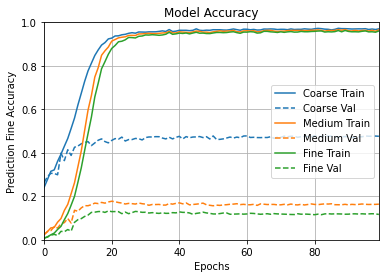

In [18]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

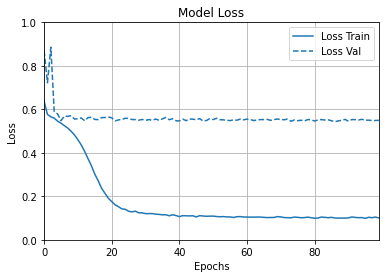

In [19]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

## Model Analysis

In [20]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

In [21]:
results = final_model.evaluate(test_dataset)
for n in range(len(results)):
    print(str(n+1)+'.',final_model.metrics_names[n], '==>', results[n])
model_predictions = final_model.predict(test_dataset)

252/252 [==============================] - 39s 139ms/step - loss: 0.5451 - prediction_coarse_loss: 0.3888 - prediction_medium_loss: 0.6448 - prediction_fine_loss: 0.6897 - prediction_coarse_accuracy: 0.4750 - prediction_medium_accuracy: 0.1639 - prediction_fine_accuracy: 0.1174
1. loss ==> 0.5451152920722961
2. prediction_coarse_loss ==> 0.38877180218696594
3. prediction_medium_loss ==> 0.6447960734367371
4. prediction_fine_loss ==> 0.6897216439247131
5. prediction_coarse_accuracy ==> 0.47500622272491455
6. prediction_medium_accuracy ==> 0.1638895869255066
7. prediction_fine_accuracy ==> 0.11738373339176178


In [22]:
def predict_from_pipeline(model, dataset):
    y_pred = []
    y_true = []
    image = []
    for x, y in dataset:
        batch_pred = model.predict(x)
        for i in range(len(batch_pred)):
            if i >= len(y_pred):
                y_pred.append(None)
                y_true.append(None)
                image.append(None)
            if y_pred[i] is None:
                y_pred[i] = batch_pred[i]
                y_true[i] = list(y[i].numpy())
                image[i] = list(x[i].numpy())
            else:
                y_pred[i] = np.concatenate([y_pred[i], batch_pred[i]])
                y_true[i] = y_true[i] + list(y[i].numpy())
                image[i] = image[i] + list(x[i].numpy())
    return y_true, y_pred, image

In [23]:
predictions = []
predictions.append(predict_from_pipeline(final_model, test_dataset))

In [24]:
dataset= {'x_test':predictions[0][2][0], 
          'y_test_coarse':predictions[0][0][0], 
          'y_test_medium':predictions[0][0][1], 
          'y_test_fine':predictions[0][0][2]}

In [25]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0][1][0],predictions[0][1][1],predictions[0][1][2]]

  • Confusion_Matrix 

  • COARSE LEVEL 
[[200  84   1   4   6  17   0   7   0 154  17   1   4]
 [ 68 258   1   0   2  40   1   4   1 203  18   4   3]
 [  4   1   0   0   0   0   0   1   0   6   1   0   0]
 [  4   4   0  54  15   3   1   1   6  10  73   1   0]
 [  1   0   0  21  25   2   0   2  12   2  24   5   0]
 [ 32  67   0   4   1  46   1   8   1 112  29   1   4]
 [  7  13   0   0   0   7   0   0   0  22   1   0   0]
 [  8  14   0   2   1   7   0  33   0  52  30   1   2]
 [  3   2   0  15   8   4   0   0  13   5  27   4   0]
 [ 66 137   0   8   2  54   1  19   1 683  76   2   9]
 [ 18  30   0  19   5  13   0  11   7  94 499   8  10]
 [  6   4   0   7   3   4   0   4   1  10  14  87   1]
 [ 13  18   0   2   0  10   0   4   1  54  30   0  12]]

  • MEDIUM LEVEL 
[[ 3  4  0 ...  0  0  0]
 [ 0 26  0 ...  1  0  0]
 [ 0  0 14 ...  0  0  0]
 ...
 [ 2  0  0 ...  0  0  0]
 [ 1  0  0 ...  0  2  0]
 [ 0  0  0 ...  0  0  2]]

  • FINE LEVEL 
[[8 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 3 3 ... 0

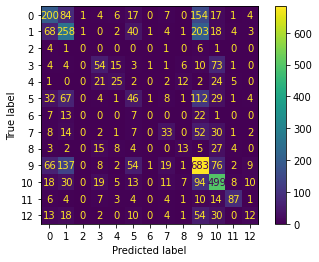

              precision    recall  f1-score   support

           0    0.46512   0.40404   0.43243       495
           1    0.40823   0.42786   0.41781       603
           2    0.00000   0.00000   0.00000        13
           3    0.39706   0.31395   0.35065       172
           4    0.36765   0.26596   0.30864        94
           5    0.22222   0.15033   0.17934       306
           6    0.00000   0.00000   0.00000        50
           7    0.35106   0.22000   0.27049       150
           8    0.30233   0.16049   0.20968        81
           9    0.48543   0.64556   0.55416      1058
          10    0.59476   0.69888   0.64263       714
          11    0.76316   0.61702   0.68235       141
          12    0.26667   0.08333   0.12698       144

    accuracy                        0.47501      4021
   macro avg    0.35567   0.30672   0.32117      4021
weighted avg    0.44980   0.47501   0.45446      4021


  • MEDIUM LEVEL 


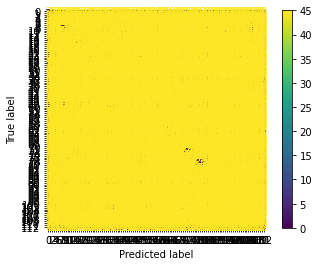

              precision    recall  f1-score   support

           0    0.07895   0.08108   0.08000        37
           1    0.20635   0.30233   0.24528        86
           2    0.31111   0.36842   0.33735        38
           3    0.12000   0.15789   0.13636        19
           4    0.11111   0.09524   0.10256        42
           5    0.17073   0.17073   0.17073        41
           6    0.16327   0.17391   0.16842        46
           7    0.10909   0.12245   0.11538        98
           8    0.10000   0.08696   0.09302        23
           9    0.18841   0.24528   0.21311       106
          10    0.28571   0.10526   0.15385        19
          11    0.50000   0.15385   0.23529        13
          12    0.06250   0.07500   0.06818        40
          13    0.15385   0.20000   0.17391        60
          14    0.06818   0.07595   0.07186        79
          15    0.23810   0.21277   0.22472        47
          16    0.01639   0.01852   0.01739        54
          17    0.24658   0

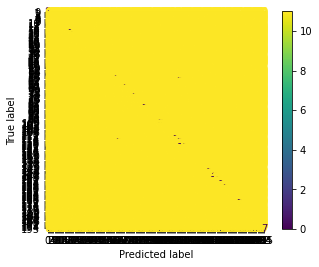

              precision    recall  f1-score   support

           0    0.30769   0.42105   0.35556        19
           1    0.00000   0.00000   0.00000        20
           2    0.09677   0.14286   0.11538        21
           3    0.25000   0.12500   0.16667        24
           4    0.09091   0.09524   0.09302        21
           5    0.16667   0.22222   0.19048        18
           6    0.15000   0.15789   0.15385        19
           7    0.08333   0.04545   0.05882        22
           8    0.04545   0.05556   0.05000        18
           9    0.12500   0.05000   0.07143        20
          10    0.21739   0.21739   0.21739        23
          11    0.06667   0.04762   0.05556        21
          12    0.00000   0.00000   0.00000        22
          13    0.00000   0.00000   0.00000        19
          14    0.12500   0.09524   0.10811        21
          15    0.05000   0.04545   0.04762        22
          16    0.06250   0.05000   0.05556        20
          17    0.25000   0

In [26]:
metrics.lvl_wise_metric(true_label,pred_label)

In [27]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,pred_label,tree)
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.23561303158418304 
Hierarchical Recall = 0.3140180717897703 
Hierarchical F1-Score = 0.26498087421986954 
Consistency =  0.2576473514051231 
Exact Match =  0.06192489430489928
